## Adaptive optimizers

In this seminar you will implement a logistic regression and train it using stochastic gradient descent modiffications, numpy and your brain.

In [25]:
#load our dakka
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with syntetic data.

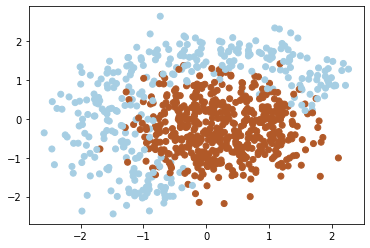

In [26]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [27]:
print("X:\n{}\ny:\n{}".format(X[:3],y[:3]))

X:
[[ 0.70169386  1.64783293]
 [-0.17597828 -0.6353715 ]
 [ 0.47142813  0.41762409]]
y:
[0 1 1]


**Your task starts here**

Since the problem above isn't linearly separable, we add quadratic features to the classifier.

Implement this transformation in the __expand__ function __[1 point]__. 

In [28]:
def expand(X):
    """
    Adds quadratic features. 
    This function allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature1*feature2, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    
    X_expanded[:, 0] = X[:, 0]
    X_expanded[:, 1] = X[:, 1]
    X_expanded[:, 2] = X[:, 0] ** 2
    X_expanded[:, 3] = X[:, 1] ** 2
    X_expanded[:, 4] = X[:, 0] * X[:, 1]
    X_expanded[:, 5] = 1.
    
    return X_expanded

In [29]:
#simple test on random numbers
#[all 8 random numbers are 100% random :P]
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

#call your expand function
dummy_expanded = expand(dummy_X)

#what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


Seems legit!


### Logistic regression (4 pts)
Now, let's write function that predicts class given X as in logistic regression.

The math should look like this:

$$ P(y| \vec x, \vec w) = \sigma(\vec x \cdot \vec w )$$

where x represents features, w are weights and $$\sigma(a) = {1 \over {1+e^{-a}}}$$

We shall omit $ \vec {arrows} $ in further formulae for simplicity.

In [30]:
def sigmoid(input):
    return 1. / (1 + np.exp(-input))

In [31]:
def classify(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    __don't forget to expand X inside classify and other functions__
    
    :param X: feature matrix X of shape [n_samples,2] (non-exanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    expanded_input = expand(X)
    
    return sigmoid(np.dot(expanded_input, w))

In [32]:
#sample usage / test just as the previous one
dummy_weights = np.linspace(-1,1,6)

dummy_probs = classify(dummy_X,dummy_weights)

dummy_answers = np.array([ 0.73105858,  0.450166  ,  0.02020883,  0.59844257])

assert isinstance(dummy_probs,np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs,dummy_answers,1e-3), "There's something non-canonic about how probabilties are computed"

The loss you should try to minimize is the Logistic Loss aka crossentropy aka negative log-likelihood:

$$ L =  - {1 \over N} \sum_i {y_i \cdot log P(y_i|x_i,w) + (1-y_i) \cdot log (1-P(y_i|x_i,w))}$$



In [40]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    y_pred = classify(X, w)
    n = X.shape[0]
    loss_sum = -np.sum(np.log(y_pred[y == 1])) - np.sum(np.log(1 - y_pred[y == 0]))
    return loss_sum / n

In [41]:
dummy_y = np.array([0,1,0,1])
dummy_loss = compute_loss(dummy_X,dummy_y,dummy_weights)

assert np.allclose(dummy_loss,0.66131), "something wrong with loss"

Since we train our model with gradient descent, we gotta compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla L = {\partial L \over \partial w} = ...$$

No, we won't be giving you the exact formula this time. Instead, try figuring out a derivative with pen and paper. 

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how L changes if you shift w by $10^{-5}$ or so).

In [42]:

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    expanded_input = expand(X)
    output = classify(expanded_input, w)
    n = X.shape[0]
    grad = np.dot(expanded_input.T, output - y) / n
    return grad

In [43]:
#tests
dummy_grads = compute_grad(dummy_X,dummy_y,dummy_weights)

#correct answers in canonic form
dummy_grads_ans = np.array([-0.06504252, -0.21728448, -0.1379879 , -0.43443953,  0.107504  , -0.05003101])

assert isinstance(dummy_grads,np.ndarray)
assert dummy_grads.shape == (6,), "must return a vector of gradients for each weight"
assert len(set(np.round(dummy_grads/dummy_grads_ans,3))), "gradients are wrong"
assert np.allclose(dummy_grads,dummy_grads_ans,1e-3), "gradients are off by a coefficient"

Here's an auxiliary function that visualizes the predictions

In [46]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1,2,2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

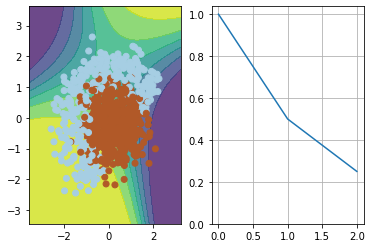

In [47]:
visualize(X,y,dummy_weights,[1,0.5,0.25],)

### Training [1 point]
In this section, we'll use the functions you wrote to train our classifier using stochastic gradient descent.

Try to find an optimal learning rate for gradient descent for the given batch size. 

**Don't change the batch size!**

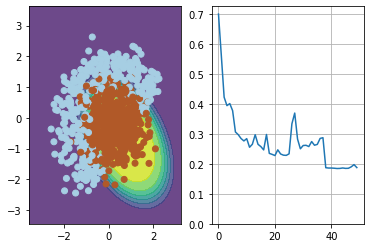

<Figure size 432x288 with 0 Axes>

In [51]:
w = np.array([0,0,0,0,0,1])


alpha = 1.

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

visualize(X, y, w, loss)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values. __[2 points]__

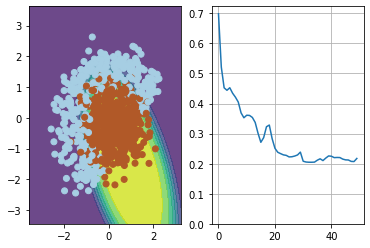

<Figure size 432x288 with 0 Axes>

In [59]:
w = np.array([0,0,0,0,0,1])
m = np.zeros(w.shape[0])

alpha = 0.5 # learning rate. Please change.
mu    = 0.5 # momentum. Please change.

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)
    
    m = mu * m + alpha * compute_grad(X[ind,:], y[ind], w)
    w = w - m

visualize(X, y, w, loss)
plt.clf()

Implement RMSPROP algorithm __[2 points]__


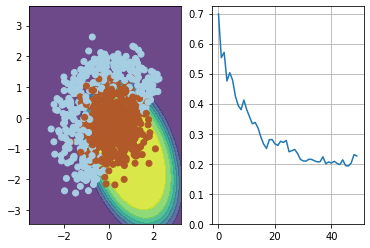

<Figure size 432x288 with 0 Axes>

In [62]:
w = np.array([0,0,0,0,0,1])
msq_grad = np.zeros(w.shape[0])

alpha = 0.2 # learning rate. Please change.
mean_squared_norm = 0.1 #moving average of gradient norm squared. Please change.

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)
    
    grad = compute_grad(X[ind,:], y[ind], w)
    msq_grad = mean_squared_norm * msq_grad + (1 - mean_squared_norm) * grad ** 2
    w = w - alpha * grad / np.sqrt(msq_grad + 1e-8)


visualize(X, y, w, loss)
plt.clf()

Which optimization method you consider the best? Type your answer in the cell below

Each optimization method for this task seems similar, and its decision curves seems similar. But vanilla gradient descent doesnt have such stability

# Bonus quest 
Try the same thing for Adagrad, Adam and anything else you find suitable.

_Each new adaptive optimizer is worth 2 points!_